In [1]:
#Initializations
import numpy as np

#Import some Qiskit work-tools:
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor

#Import Qiskit visualization-tools:
from qiskit.visualization import plot_histogram

provider = IBMQ.load_account()

# Qiskit Implementation of Deutsch-Joza Algorithm:

## I. Step-by-step implementation:

### 0. Set-up:

In [59]:
#Set the number of bits and the bit string:
n = 3
bit_string = "1"

### 1. Constructing Constant Oracle:

The input actually has no effect on the output.

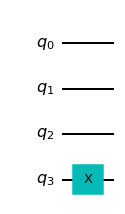

In [60]:
#Get the constant oracle circuit:
constant_oracle = QuantumCircuit(n+1)

#Randomly set the output qubit to 0 or 1:
output_qubit = np.random.randint(2)

if output_qubit:
    constant_oracle.x(n) #Make the output qubit 1.

constant_oracle.draw()

### 2. Constructing Balanced Oracle:

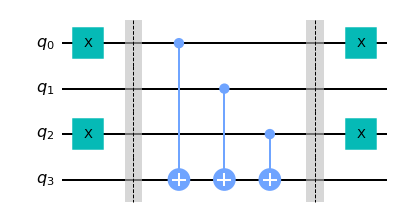

In [61]:
#Get the balanced oracle circuit:
balanced_oracle = QuantumCircuit(n+1)

#Flip the states from |0> to |1> for the states that are 1 in the bit-string:
for qubit in range(n):
    if bit_string[qubit] == '1':
        balanced_oracle.x(qubit)

#Add barriers:
balanced_oracle.barrier()

#Take care of the output qubit:
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

#Add barriers:
balanced_oracle.barrier()

#Wrap-up the circuit with NOT gates:
for qubit in range(n):
    if bit_string[qubit] == '1':
        balanced_oracle.x(qubit)

balanced_oracle.draw()

### 3. Assembling for Deutsch-Joza:
#### a) State preparation:

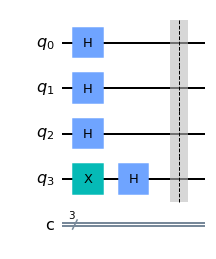

In [62]:
#Get the Deutsch-Jozsa quantum circuit:
dj_qc = QuantumCircuit(n+1, n)

#Initialize the input states to |+>:
for qubit in range(n):
    dj_qc.h(qubit) #H|0> = |+>

#Initialize the output state to |->:
dj_qc.x(n) #X|0> = |1>
dj_qc.h(n) #H|1> = |->

#Add barriers:
dj_qc.barrier()

dj_qc.draw()

#### b) Apply the oracles: 

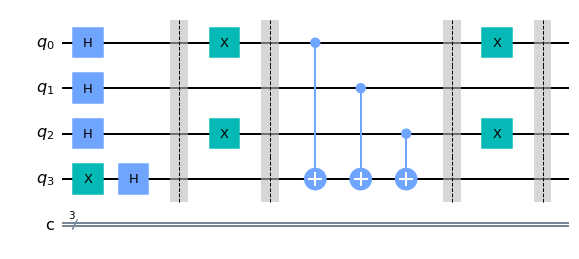

In [63]:
dj_qc += balanced_oracle

#Add barriers:
dj_qc.barrier()

dj_qc.draw()

#### c) Perform superposition and measure:

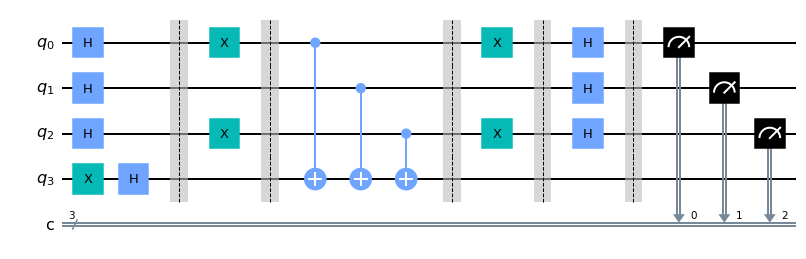

In [64]:
#Apply H-gates:
for qubit in range(n):
    dj_qc.h(qubit)

#Add barriers:
dj_qc.barrier()

#Measure the qubits: 
for i in range(n):
    dj_qc.measure(i, i)

dj_qc.draw()

#### d) Output time!

On local simulator:

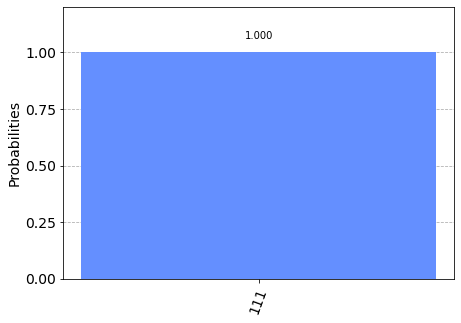

In [65]:
#Run it on local simulator:

backend = BasicAer.get_backend('qasm_simulator') #Fetching the backend...
shots = 1024 #Defining shots...

#Getting the result of the execution:
results = execute(dj_qc, backend = backend, shots = shots).result() 

#Get the data to plot:
answer = results.get_counts()

#Plot the histogram:
plot_histogram(answer)

## II. Generalized implementation:

In [ ]:
def phase_oracle(case, n):
    '''
    Brief: This method will return a QuantumCircuit object.
           The circuit that is being returned will have n+1 qubits:
           n for the input size and one output qubit.
    Arguments: 
        - case => The function, f(x), is balanced or constant.
        - n => The number of qubits that are being used.
    '''
    
    #Create the oracle circuit:
    oracle_qc = QuantumCircuit(n+1)
    
    #In the case f(x) is balanced:
    if case == "balanced":
        #We apply the C-NOT gate on each qubit with the target 
        #being on the output or the (n+1)th qubit.
        #Suppose, the string is 01011011: 
        #Final state will be 1 for odd number of 1's.
        #Basically, we're mapping the parity of the input to make 
        #sure half of the input will map to 0 and half 1. 
        
        for qubit in range(n): #Loop will run from 0 to (n-1). 
            oracle_qc.cx(qubit, n)
            
    #In the case f(x) is constant:
    if case == "constant":
        #First we have to decide what the fixed output of the
        #oracle is going to be, i.e., either always 0 or always 1.
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n) #Flip the last qubit. 
            

    oracle_gate = oracle_qc.to_gate() #Converts the entire circuit
                                      #to a quantum gate.
    oracle_gate.name = "Phase Oracle"
    
    return oracle_gate

In [3]:
def deutsch_joza(n, case = "anything"):
    dj_qc = QuantumCircuit(n+1, n)
    #Input state preparation:
    for qubit in range(n):
        dj_qc.h(qubit) #Send each qubit to superposition!
    
    #Output state preparation:
    dj_qc.x(n) # |0> -> |1>
    dj_qc.h(n) # |1> -> |->
    
    #What's f(x)- balanced or constant?
    if case == "anything":
        case_is = np.random.randint(2)
        if case_is == 0:
            case = "constant"
        else:
            case = "balanced" 
                
    #Append the phase oracle gate to our circuit:
    ph_oracle = phase_oracle(case, n)
    dj_qc.append(ph_oracle, range(n+1)) #For all the qubits.
    
    #Finally, send all the input qubits to superposition and
    #measure to get the classical output:
    for i in range(n):
        dj_qc.h(i)
        dj_qc.measure(i, i)
    
    return dj_qc
        

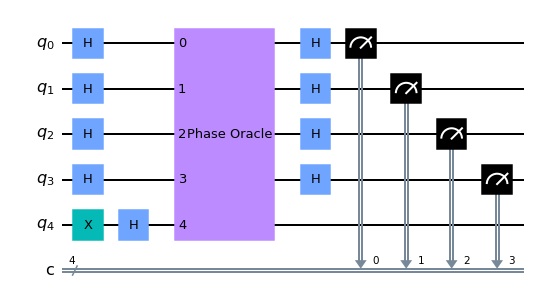

In [4]:
n = 4
final_dj_qc = deutsch_joza(n)
final_dj_qc.draw()

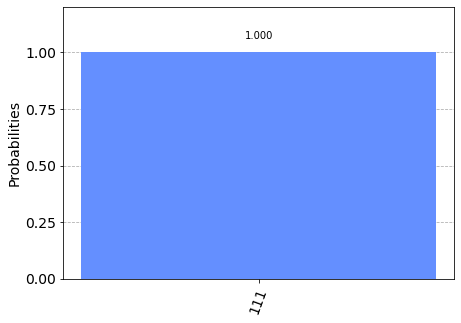

In [50]:
#Run it on local simulator:

backend = BasicAer.get_backend('qasm_simulator') #Fetching the backend...
shots = 1 #Defining shots...

#Getting the result of the execution:
results = execute(dj_qc, backend = backend, shots = shots).result() 

#Get the data to plot:
answer = results.get_counts()

#Plot the histogram:
plot_histogram(answer)

In [66]:
#Get the provider
provider = IBMQ.get_provider(hub = 'ibm-q') 

In [52]:
#Check the quantum devices available:
all_providers = provider.backends()
for device in all_providers:
    print(device)

ibmq_qasm_simulator
ibmq_armonk
ibmq_santiago
ibmq_bogota
ibmq_lima
ibmq_belem
ibmq_quito
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer
ibmq_manila


In [53]:
#Desired conditions:
desired_filter = lambda x: x.configuration().n_qubits >= (n+1) and not x.configuration().simulator and x.status().operational == True

#Desired quantum devices available:
desired_providers = provider.backends(filters = desired_filter)
for device in desired_providers:
    print(device)

ibmq_santiago
ibmq_bogota
ibmq_lima
ibmq_belem
ibmq_quito
ibmq_manila


In [55]:
#Run it on the actual quantum device:

qcomp = least_busy(provider.backends(filters = desired_filter)) #Fetch the least busy backend.

print(f"The least busy backend avaiable is: {qcomp}") #Print the least busy quantum device.

%qiskit_job_watcher #Enable the pop-up tab that gives you the status of your job.

#final_dj_qc = deutsch_joza(n) #Get the final circuit.

job = execute(dj_qc, backend = qcomp, shots = shots) #Execute the job

The least busy backend avaiable is: ibmq_bogota


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

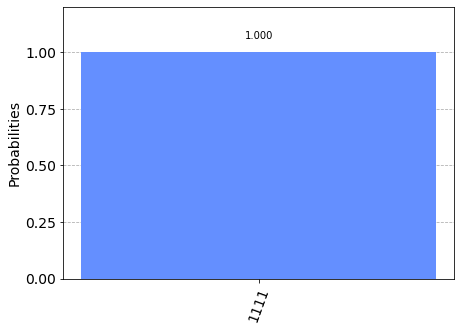

In [10]:
#Get the results:
result = job.result()

#Get the data to plot:
answer = result.get_counts()

#Finally, plot the data:
plot_histogram(answer)

In [67]:
qcomp = provider.get_backend('ibmq_quito')
job = execute(final_dj_qc, backend = qcomp, shots = shots)

In [13]:
result = job.result(final_dj_qc)
plot_histogram(result.get_counts())

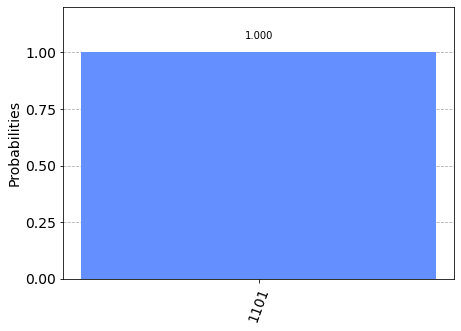

In [14]:
plot_histogram(result.get_counts())